In [ ]:


import os
import cv2
import random
import numpy as np
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import torchmetrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# ============================================================
# CELL 2 — Regenerate CLEAN dataset (40,000 Images)
# ============================================================

from pycocotools.coco import COCO
import numpy as np
import cv2
from PIL import Image
import os, tqdm

RAW_IMG_DIR = "/content/train_subset/train2017"
ANNOT_PATH  = "/content/annotations/annotations/instances_train2017.json"

PROC_DIR = "/content/processed"
IMG_DIR  = f"{PROC_DIR}/images"
MASK_DIR = f"{PROC_DIR}/masks"
BIN_DIR  = f"{PROC_DIR}/binary_masks"

!rm -rf /content/processed
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)
os.makedirs(BIN_DIR, exist_ok=True)

coco = COCO(ANNOT_PATH)
img_ids = coco.getImgIds()

IMG_SIZE = 256
MAX_IMAGES = 40000     # your requirement

print("Regenerating CLEAN dataset for 40,000 images...")
saved = 0

for img_id in tqdm.tqdm(img_ids[:MAX_IMAGES]):
    info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(RAW_IMG_DIR, info["file_name"])
    if not os.path.exists(img_path):
        continue

    # load and resize image
    img = np.array(Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE)))

    # load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    if len(anns) == 0:
        continue

    # build mask
    mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    for ann in anns:
        m = coco.annToMask(ann)
        m = cv2.resize(m, (IMG_SIZE, IMG_SIZE))
        mask = np.maximum(mask, m)

    # ignore empty masks
    if mask.sum() < 50:
        continue

    name = info["file_name"].replace(".jpg", "")

    Image.fromarray(img).save(f"{IMG_DIR}/{name}.jpg")
    Image.fromarray(mask * 255).save(f"{MASK_DIR}/{name}.png")
    Image.fromarray((mask > 0).astype(np.uint8) * 255).save(f"{BIN_DIR}/{name}.png")

    saved += 1

print("Final saved:", saved)


loading annotations into memory...
Done (t=16.96s)
creating index...
index created!
Regenerating CLEAN dataset for 40,000 images...


100%|██████████| 40000/40000 [11:25<00:00, 58.34it/s]

Final saved: 39605


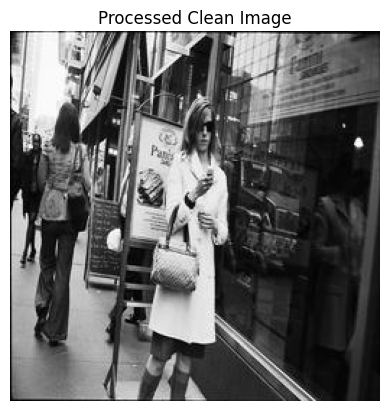

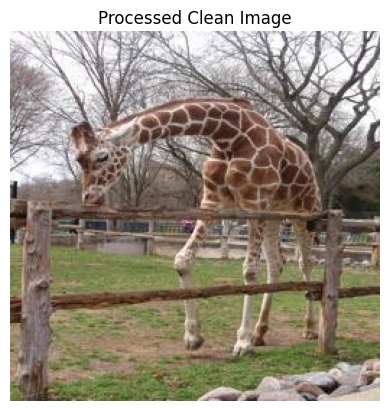

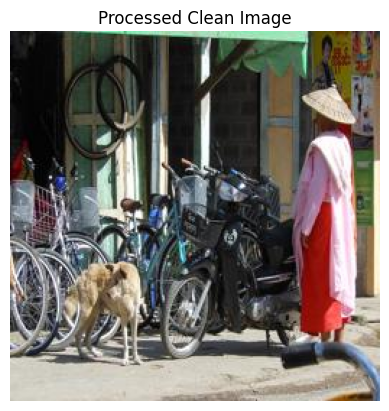

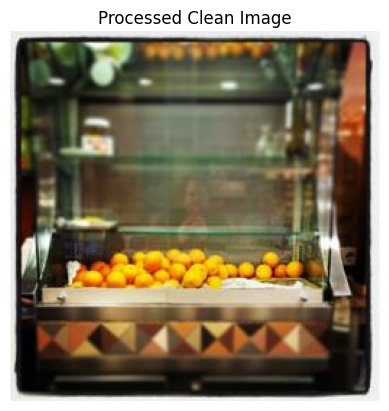

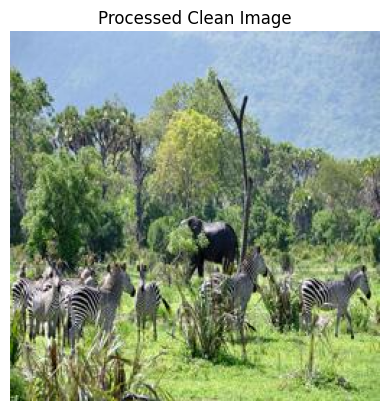

In [10]:
# ============================================================
# CELL 3 — Visual sanity-check
# ============================================================

files = os.listdir(IMG_DIR)
for f in random.sample(files, 5):
    img = Image.open(f"{IMG_DIR}/{f}")
    plt.imshow(img)
    plt.title("Processed Clean Image")
    plt.axis("off")
    plt.show()


In [11]:
# ============================================================
# CELL 4 — Dataset Class(CPU Optimized)
# ============================================================

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, ids, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
      name = self.ids[idx]

      img = np.array(Image.open(f"{self.img_dir}/{name}.jpg").convert("RGB"))
      mask = np.array(Image.open(f"{self.mask_dir}/{name}.png").convert("L"))
      mask = (mask > 127).astype(np.uint8)

      if self.transform:
          aug = self.transform(image=img, mask=mask)
          img = aug["image"]
          mask = aug["mask"]

      # img is already a Tensor from ToTensorV2
      img = img.float()

      # ------ FIX STARTS HERE ------
      if isinstance(mask, np.ndarray):
          mask = torch.from_numpy(mask)

      # ensure correct shape: (1,H,W)
      if mask.ndim == 2:
          mask = mask.unsqueeze(0)
      elif mask.ndim == 3:
          mask = mask[0].unsqueeze(0)
      # convert to float
      mask = mask.float()
      # ------ FIX ENDS HERE ------

      return img, mask, name


In [12]:
# ============================================================
# CELL 5 — Train/Validation Split + DataLoaders
# ============================================================

all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(IMG_DIR)])
random.shuffle(all_ids)

split = int(0.8 * len(all_ids))
train_ids = all_ids[:split]
val_ids = all_ids[split:]

print("Train:", len(train_ids), "Val:", len(val_ids))

train_tf = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(256,256),
    ToTensorV2()
])

train_ds = SegmentationDataset(IMG_DIR, BIN_DIR, train_ids, train_tf)
val_ds   = SegmentationDataset(IMG_DIR, BIN_DIR, val_ids, val_tf)

batch_size = 4   # CPU recommended
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)



Train: 31684 Val: 7921


In [13]:
# ============================================================
# 🧩 Cell 6 — Custom U-Net (Training From Scratch)
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

# ---- U-Net building blocks ----
class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.pool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Final 1x1 convolution"""
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# ---- Full U-Net ----
class UNetScratch(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNetScratch, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# ---- Initialize model ----
model = UNetScratch(n_channels=3, n_classes=1).to(device)
print("✅ Custom U-Net model initialized (no pretraining) on:", device)

# ---- Loss functions ----
bce_loss = nn.BCEWithLogitsLoss()

def dice_loss_logits(preds, targets, smooth=1.):
    preds = torch.sigmoid(preds)
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (preds * targets).sum(1)
    dice = (2. * intersection + smooth) / (preds.sum(1) + targets.sum(1) + smooth)
    return 1 - dice.mean()

def combined_loss(preds, targets, bce_weight=0.5):
    return bce_weight * bce_loss(preds, targets) + (1 - bce_weight) * dice_loss_logits(preds, targets)


✅ Custom U-Net model initialized (no pretraining) on: cuda


In [14]:
# ============================================================
# CELL 7 — Optimizer + Loss + Metrics (CPU Mode)
# ============================================================

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

checkpoint_dir = "/content/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_iou = 0



In [15]:
# ============================================================
# CELL 8 — Training & Validation Loops (CPU Safe)
# ============================================================

def train_one_epoch(epoch):
    model.train()
    running = 0.0
    for imgs, masks, _ in tqdm.tqdm(train_loader, desc=f"Train E{epoch}"):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        optimizer.step()

        running += loss.item()

    return running / len(train_loader)


@torch.no_grad()
def validate(epoch):
    model.eval()
    tot_loss = 0
    ious = []

    for imgs, masks, _ in tqdm.tqdm(val_loader, desc=f"Val E{epoch}"):
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        loss = combined_loss(logits, masks)
        tot_loss += loss.item()

        preds = (torch.sigmoid(logits) > 0.5).int()
        ious.append(iou_metric(preds, masks.int()).item())

    return tot_loss / len(val_loader), np.mean(ious)


In [16]:
# ============================================================
# CELL 9 — Main Training Loop (CPU Friendly)
# ============================================================

EPOCHS = 5   # CPU training → do 15 first, continue later

for epoch in range(1, EPOCHS+1):
    tr = train_one_epoch(epoch)
    vl, iou = validate(epoch)

    scheduler.step(iou)

    print(f"[E{epoch}] Train={tr:.4f}  Val={vl:.4f}  IoU={iou:.4f}")

    torch.save(model.state_dict(), f"{checkpoint_dir}/last_epoch.pth")

    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pth")
        print("🔥 Saved BEST model!")


Val E1: 100%|██████████| 1981/1981 [01:54<00:00, 17.33it/s]


[E1] Train=0.4921  Val=0.4225  IoU=0.5402
🔥 Saved BEST model!


Val E2: 100%|██████████| 1981/1981 [01:54<00:00, 17.31it/s]


[E2] Train=0.4243  Val=0.3996  IoU=0.5615
🔥 Saved BEST model!


Val E3: 100%|██████████| 1981/1981 [01:54<00:00, 17.36it/s]


[E3] Train=0.3987  Val=0.3760  IoU=0.5795
🔥 Saved BEST model!


Val E4: 100%|██████████| 1981/1981 [01:54<00:00, 17.36it/s]


[E4] Train=0.3807  Val=0.3663  IoU=0.5897
🔥 Saved BEST model!


Val E5: 100%|██████████| 1981/1981 [01:54<00:00, 17.32it/s]


[E5] Train=0.3679  Val=0.3616  IoU=0.5747


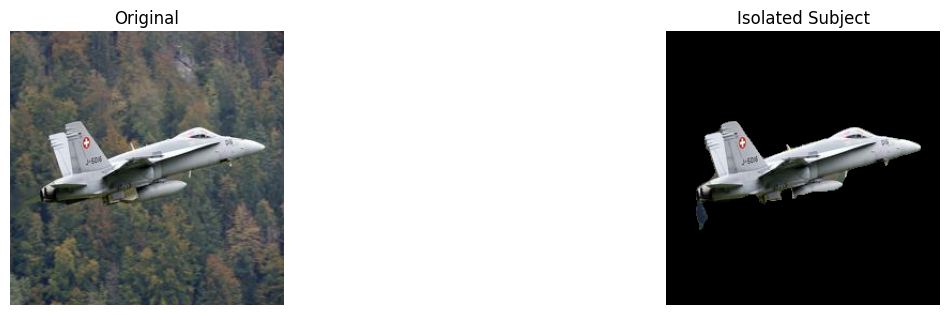

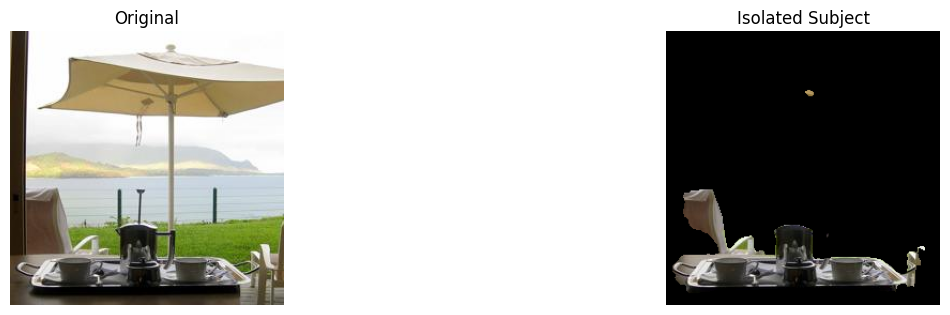

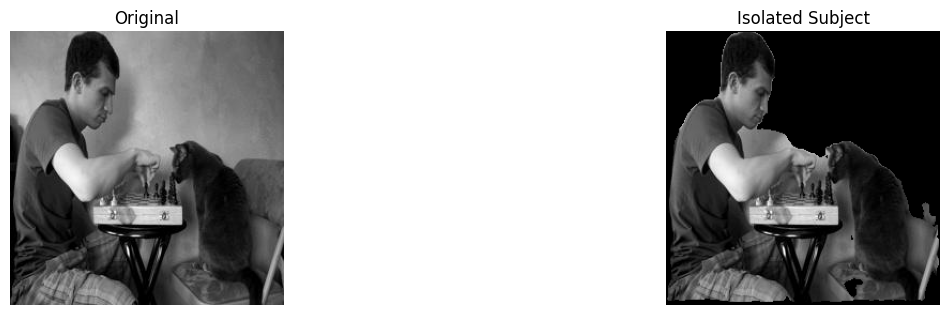

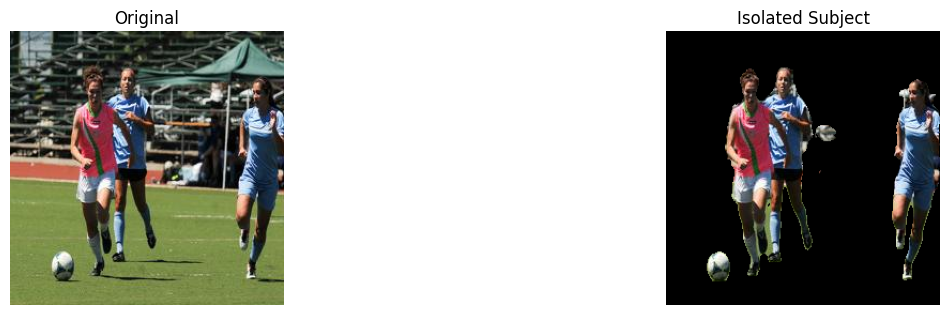

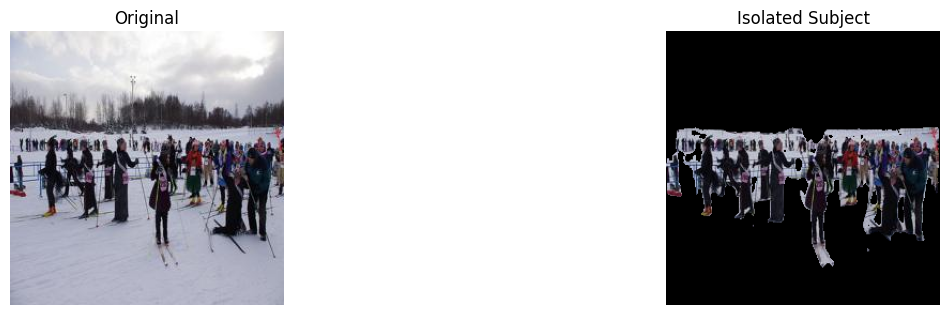

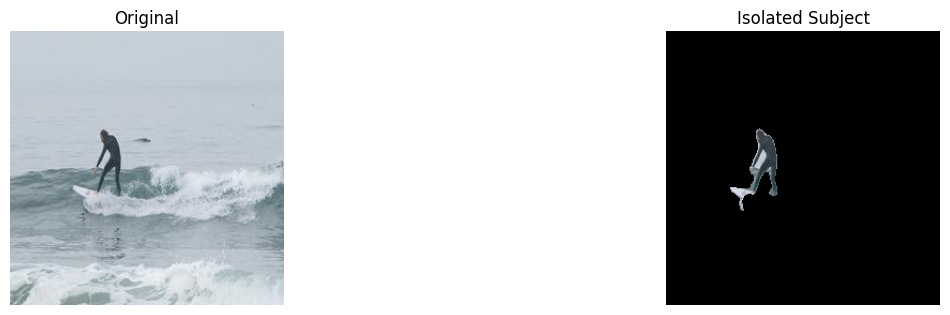

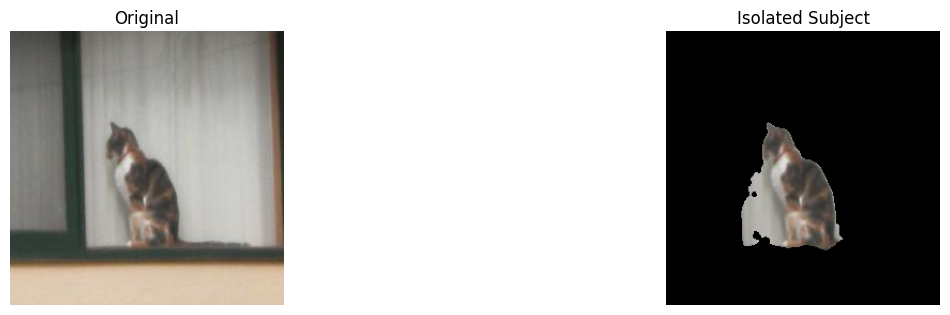

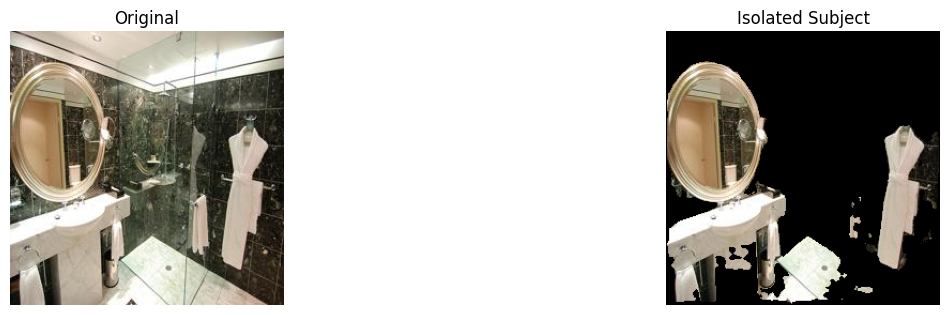

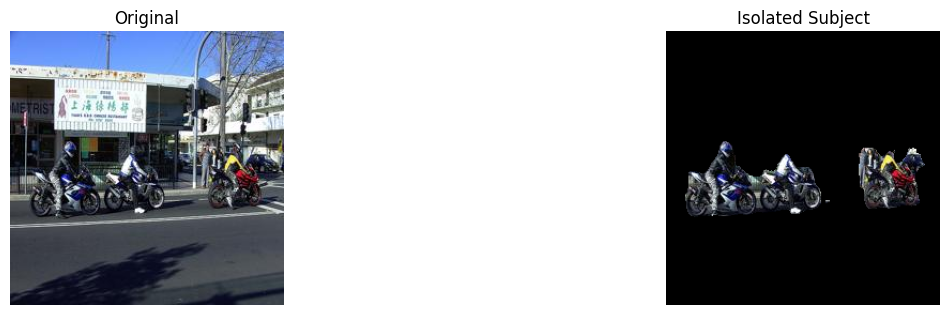

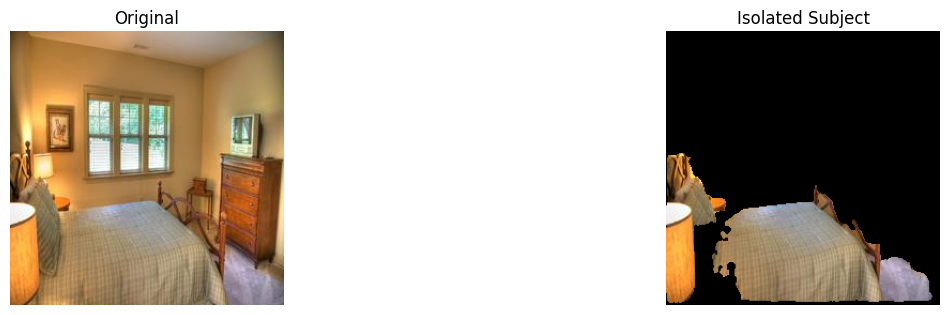

In [17]:
# ============================================================
# Correct Visualizer — uses SAME transforms as validation
# ============================================================

model.load_state_dict(torch.load("/content/checkpoints/best_model.pth"))
model.eval()

# use SAME transform as validation
infer_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

vis_ids = random.sample(val_ids, 10)

for name in vis_ids:

    # Load image
    img = np.array(Image.open(f"{IMG_DIR}/{name}.jpg").convert("RGB"))

    # Albumentations inference
    aug = infer_transform(image=img)
    img_tensor = aug["image"].float().unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor))[0,0].cpu().numpy()

    pred_bin = (pred > 0.5).astype(np.uint8)

    # Resize back to original image size if needed
    resized_pred = cv2.resize(pred_bin.astype("uint8"), (img.shape[1], img.shape[0]))

    # Apply to isolate subject
    isolated = img * resized_pred[..., None]

    # Plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
    #plt.subplot(1,3,2); plt.imshow(pred, cmap="inferno"); plt.title("Pred Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(isolated); plt.title("Isolated Subject"); plt.axis("off")
    plt.show()
